In [1]:
# Import libraries
# TODO: Clean this again, to only contain libraries for this part
import pandas as pd
import gc #gc.collect()
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchaudio
#from torchaudio import transforms
import librosa
import librosa.display
from datasets import Dataset
from collections import Counter
from pathlib import Path
import torchaudio
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image

In [97]:
# Modified version from HA1
class InstrumentsData(Dataset):
    def __init__(self, root, transform, guitar_label=0, piano_label=1, drum_label=2):
        """Constructor
        
        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """
        
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")
            
        self.root = root
        self.transform = transform
        self._guitar_label = guitar_label
        self._piano_label = piano_label
        self._drum_label = drum_label
        
        # Collect samples, both cat and dog and store pairs of (filepath, label) in a simple list.
        self._samples = self._collect_samples()
        
    def __len__(self):
        return len(self._samples)
        
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label
    
        
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        # Iterator over dog filpath
        guitar_paths = self._collect_imgs_sub_dir(self.root / "Mel_guitar")
        # Iterator of pairs (path, dog label)
        # Again, we use the `map` function to create an iterator. It's use is not as common as the so called
        # 'list comprehension' you've previously seen, but a good alternative to have seen.
        guitar_paths_and_labels = map(lambda path: (path, self._guitar_label), guitar_paths)
        # Same for cats
        piano_paths = self._collect_imgs_sub_dir(self.root / "Mel_piano")
        piano_paths_and_labels = map(lambda path: (path, self._piano_label), piano_paths)
        
        #drum_paths = self._collect_imgs_sub_dir(self.root / "Mel_drum")
        #drum_paths_and_labels = map(lambda path: (path, self._drum_label), drum_paths)
        # Sorting is not strictly necessary, but filesystem globbing (wildcard search) is not deterministic,
        # and consistency is nice when debugging.
        #return sorted(list(chain(guitar_paths_and_labels, piano_paths_and_labels, drum_paths_and_labels)), key=lambda x: x[0].stem)
        return sorted(list(chain(guitar_paths_and_labels, piano_paths_and_labels)), key=lambda x: x[0].stem)
        
    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.jpg")
    
    def get_sample_by_id(self, id_):
        """Get sample by image id
        
        Convenience method for exploration.
        The indices does not correspond to the image id's in the filenames.
        Here is a (rather inefficient) way of inspecting a specific image.
        
        Args:
            id_ (str): Image id, e.g. `dog.321`
        """
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]

In [98]:
transform = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

In [99]:
train_dataloader = DataLoader(InstrumentsData("train", transform), batch_size = 32, shuffle=True)
val_dataloader = DataLoader(InstrumentsData("val", transform), batch_size = 32, shuffle=True)

In [100]:
class FirstCnn(nn.Module):
    def __init__(self, img_size):
        super(FirstCnn, self).__init__()
        self.first_conv_layer = nn.Conv2d(in_channels=3, kernel_size=3, stride=1, padding=0, out_channels=10)
        self.second_conv_layer = nn.Conv2d(in_channels=10, kernel_size=3, stride=1, padding=0, out_channels=10)
        self.fully_connected_layer = nn.Linear(
            in_features=(img_size-4)*(img_size-4)*10,
            out_features=3
        )
    
    def forward(self, input_batch):
        out = self.first_conv_layer(input_batch)
        out = self.second_conv_layer(out)
        np_flat = out.reshape(input_batch.size(0) ,(out.size(dim=1)*out.size(dim=2)*out.size(dim=3)))
        z = self.fully_connected_layer(np_flat)
        return torch.softmax(z, dim=1).squeeze()

In [101]:
# Borrowed from HA1
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        #z = output_to_label(z)
        print(f'z: {z}')
        print(f' lab: {labels.long()}')
        loss = loss_fn(z, labels.long())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.long())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)

In [102]:
def output_to_label(z):   
    c = []
    for preds in z:
        pred = torch.argmax(preds)       
        c.append(pred.float())
    #device = "cuda"
    return torch.tensor(c)#.to(device)

In [103]:
# TODO: Train for more reasonable amount of samples. Add a validation set.
loss_fn = nn.CrossEntropyLoss()
network = FirstCnn(32)
optim = torch.optim.Adam(network.parameters(),lr=1e-3)

first_model, first_train_losses, first_train_accs, first_val_losses, first_val_accs = training_loop(network, optim, loss_fn, train_dataloader, val_dataloader, 2, 10)

Starting training
z: tensor([[0.3072, 0.3699, 0.3230],
        [0.3198, 0.3541, 0.3261],
        [0.3243, 0.3564, 0.3194],
        [0.3181, 0.3548, 0.3271],
        [0.3060, 0.3743, 0.3197],
        [0.3083, 0.3790, 0.3127],
        [0.3046, 0.3699, 0.3254],
        [0.3045, 0.3724, 0.3231],
        [0.3060, 0.3687, 0.3252],
        [0.3082, 0.3640, 0.3278],
        [0.3198, 0.3597, 0.3205],
        [0.3218, 0.3522, 0.3260],
        [0.3065, 0.3694, 0.3240],
        [0.3085, 0.3713, 0.3202],
        [0.3131, 0.3701, 0.3168],
        [0.3080, 0.3813, 0.3106],
        [0.3114, 0.3686, 0.3199],
        [0.3145, 0.3660, 0.3195],
        [0.3100, 0.3625, 0.3275],
        [0.3049, 0.3693, 0.3258],
        [0.3122, 0.3671, 0.3208],
        [0.3033, 0.3691, 0.3276],
        [0.3120, 0.3650, 0.3230],
        [0.3098, 0.3721, 0.3181],
        [0.3000, 0.3813, 0.3187],
        [0.3086, 0.3694, 0.3220],
        [0.3013, 0.3838, 0.3149],
        [0.3083, 0.3643, 0.3274],
        [0.3072, 0.3796, 0.

z: tensor([[1.5692e-01, 8.4300e-01, 7.4973e-05],
        [1.6187e-01, 8.3806e-01, 7.0231e-05],
        [7.4838e-01, 2.5060e-01, 1.0203e-03],
        [1.2523e-01, 8.7474e-01, 3.1947e-05],
        [6.5706e-01, 3.3994e-01, 2.9967e-03],
        [6.5504e-01, 3.4442e-01, 5.3175e-04],
        [1.8807e-01, 8.1185e-01, 8.6020e-05],
        [4.8271e-01, 5.1568e-01, 1.6103e-03],
        [5.0523e-01, 4.9437e-01, 4.0048e-04],
        [4.9536e-01, 5.0301e-01, 1.6347e-03],
        [1.5417e-01, 8.4582e-01, 6.4501e-06],
        [5.4654e-01, 4.5308e-01, 3.8292e-04],
        [4.8639e-01, 5.1353e-01, 7.6204e-05],
        [2.6604e-01, 7.3380e-01, 1.6238e-04],
        [5.8087e-01, 4.1781e-01, 1.3145e-03],
        [5.6726e-01, 4.3203e-01, 7.1554e-04],
        [6.4548e-01, 3.5401e-01, 5.0475e-04],
        [2.5726e-01, 7.4268e-01, 5.9299e-05],
        [3.3170e-01, 6.6787e-01, 4.3036e-04],
        [6.7069e-01, 3.2911e-01, 2.0465e-04],
        [3.4917e-01, 6.5082e-01, 3.5132e-06],
        [1.7184e-01, 8.2810e-01

z: tensor([[9.1615e-01, 8.3838e-02, 9.7884e-06],
        [3.3075e-01, 6.6925e-01, 1.7826e-06],
        [7.9357e-01, 2.0639e-01, 4.1625e-05],
        [8.7139e-01, 1.2860e-01, 1.2468e-05],
        [1.0823e-01, 8.9177e-01, 1.5387e-07],
        [8.2332e-01, 1.7668e-01, 5.2845e-06],
        [7.9164e-02, 9.2084e-01, 5.1654e-08],
        [8.6946e-01, 1.3054e-01, 8.1399e-08],
        [9.1427e-01, 8.5733e-02, 1.1920e-06],
        [6.6527e-01, 3.3473e-01, 2.0327e-06],
        [1.1813e-01, 8.8187e-01, 2.7904e-08],
        [8.6518e-01, 1.3477e-01, 5.4520e-05],
        [2.7593e-01, 7.2407e-01, 1.8122e-08],
        [6.0696e-01, 3.9304e-01, 1.9271e-06],
        [5.3087e-01, 4.6913e-01, 8.1306e-07],
        [3.3263e-02, 9.6674e-01, 1.9980e-08],
        [9.0071e-01, 9.9287e-02, 3.2433e-06],
        [5.8912e-01, 4.1088e-01, 7.1461e-07],
        [1.7151e-01, 8.2849e-01, 1.6644e-08],
        [1.3069e-01, 8.6931e-01, 6.3666e-08],
        [1.5925e-01, 8.4075e-01, 2.6368e-07],
        [8.5650e-01, 1.4350e-01

z: tensor([[9.7072e-01, 2.9281e-02, 4.8019e-07],
        [9.1229e-01, 8.7710e-02, 2.3614e-07],
        [2.6549e-02, 9.7345e-01, 1.6329e-11],
        [4.0971e-01, 5.9029e-01, 7.2693e-12],
        [9.8584e-01, 1.4159e-02, 8.4893e-07],
        [1.9976e-01, 8.0024e-01, 1.7521e-09],
        [9.4272e-01, 5.7280e-02, 1.7033e-06],
        [9.6685e-01, 3.3152e-02, 2.0118e-06],
        [9.7223e-01, 2.7771e-02, 2.9734e-12],
        [9.8577e-01, 1.4223e-02, 2.6026e-06],
        [7.0942e-02, 9.2906e-01, 9.9792e-10],
        [3.0498e-01, 6.9502e-01, 2.1660e-08],
        [3.4136e-02, 9.6586e-01, 9.6208e-10],
        [2.5082e-01, 7.4918e-01, 5.5908e-12],
        [8.0201e-01, 1.9799e-01, 8.2517e-07],
        [9.2216e-01, 7.7840e-02, 1.7711e-06],
        [8.5085e-02, 9.1492e-01, 4.2195e-10],
        [9.6586e-01, 3.4144e-02, 4.6411e-08],
        [9.4009e-01, 5.9908e-02, 2.1211e-10],
        [9.2076e-01, 7.9245e-02, 4.6138e-08],
        [9.5450e-01, 4.5502e-02, 6.8875e-08],
        [3.9470e-02, 9.6053e-01

z: tensor([[7.0081e-03, 9.9299e-01, 3.0276e-13],
        [2.0217e-03, 9.9798e-01, 9.3876e-14],
        [1.6975e-02, 9.8302e-01, 1.7839e-10],
        [2.5144e-02, 9.7486e-01, 2.4984e-11],
        [6.8593e-02, 9.3141e-01, 5.0521e-10],
        [9.9654e-01, 3.4593e-03, 9.9681e-09],
        [2.6152e-02, 9.7385e-01, 2.0417e-12],
        [6.9505e-01, 3.0495e-01, 1.5619e-09],
        [1.3022e-01, 8.6978e-01, 3.0660e-09],
        [2.7249e-03, 9.9728e-01, 1.1381e-12],
        [8.2098e-03, 9.9179e-01, 9.6228e-12],
        [6.4812e-01, 3.5188e-01, 7.6599e-11],
        [9.9429e-01, 5.7125e-03, 3.3271e-07],
        [8.3203e-01, 1.6797e-01, 2.7244e-10],
        [2.4394e-02, 9.7561e-01, 7.3882e-10],
        [5.6744e-03, 9.9433e-01, 7.3865e-12],
        [1.6935e-01, 8.3065e-01, 1.0352e-11],
        [9.1799e-01, 8.2015e-02, 8.2297e-09],
        [8.2505e-01, 1.7495e-01, 3.0440e-09],
        [6.7553e-01, 3.2447e-01, 1.0884e-07],
        [9.9683e-01, 3.1680e-03, 1.0372e-08],
        [3.6587e-02, 9.6341e-01

z: tensor([[1.0389e-03, 9.9896e-01, 9.5493e-13],
        [8.6373e-01, 1.3627e-01, 1.0321e-07],
        [1.7424e-02, 9.8258e-01, 1.9454e-11],
        [9.9698e-01, 3.0248e-03, 1.3616e-09],
        [9.9481e-01, 5.1875e-03, 7.7869e-10],
        [5.1801e-03, 9.9482e-01, 1.5557e-11],
        [9.9815e-01, 1.8534e-03, 8.9736e-10],
        [7.6515e-01, 2.3485e-01, 5.0538e-08],
        [7.7843e-03, 9.9222e-01, 1.0902e-12],
        [4.8789e-01, 5.1211e-01, 1.7335e-11],
        [9.7414e-04, 9.9903e-01, 2.7358e-13],
        [4.2992e-03, 9.9570e-01, 2.2084e-11],
        [9.9396e-01, 6.0351e-03, 5.0087e-12],
        [9.6768e-02, 9.0323e-01, 3.7614e-09],
        [2.1622e-02, 9.7838e-01, 2.9971e-12],
        [8.6300e-01, 1.3700e-01, 4.4586e-10],
        [9.9824e-01, 1.7608e-03, 2.4250e-09],
        [9.9804e-01, 1.9584e-03, 5.4339e-10],
        [9.9618e-01, 3.8152e-03, 1.5072e-09],
        [3.2935e-02, 9.6706e-01, 5.6737e-11],
        [2.3448e-02, 9.7655e-01, 8.6407e-13],
        [9.9862e-01, 1.3814e-03

z: tensor([[9.9997e-01, 3.3789e-05, 3.8032e-10],
        [9.9999e-01, 5.3701e-06, 7.8588e-15],
        [9.9895e-01, 1.0513e-03, 4.2248e-11],
        [9.9984e-01, 1.6244e-04, 9.0826e-13],
        [9.9263e-01, 7.3720e-03, 2.0939e-16],
        [4.3739e-03, 9.9563e-01, 2.5854e-14],
        [9.8776e-01, 1.2237e-02, 2.8967e-15],
        [9.9345e-01, 6.5524e-03, 2.4867e-08],
        [2.8162e-01, 7.1838e-01, 3.3563e-14],
        [6.7499e-03, 9.9325e-01, 3.3614e-14],
        [9.9509e-01, 4.9079e-03, 8.7223e-14],
        [9.8310e-01, 1.6902e-02, 1.9438e-09],
        [9.9991e-01, 8.7880e-05, 4.2232e-15],
        [2.8677e-01, 7.1323e-01, 1.7761e-11],
        [9.9998e-01, 1.8979e-05, 2.3770e-12],
        [1.9308e-02, 9.8069e-01, 2.9058e-14],
        [7.7715e-01, 2.2284e-01, 3.3443e-10],
        [9.4492e-01, 5.5085e-02, 3.7724e-17],
        [6.5633e-02, 9.3437e-01, 9.3976e-16],
        [9.9916e-01, 8.3950e-04, 8.1676e-10],
        [9.9514e-01, 4.8646e-03, 3.0532e-08],
        [9.9691e-01, 3.0898e-03

z: tensor([[8.9171e-06, 9.9999e-01, 2.8703e-17],
        [9.9266e-01, 7.3385e-03, 1.6333e-09],
        [6.0114e-01, 3.9886e-01, 3.6129e-09],
        [3.9649e-02, 9.6035e-01, 1.2866e-10],
        [9.9067e-01, 9.3308e-03, 2.8425e-13],
        [1.4844e-03, 9.9852e-01, 2.3774e-13],
        [9.9751e-01, 2.4926e-03, 5.5798e-11],
        [9.9944e-01, 5.5943e-04, 5.3712e-10],
        [5.7963e-01, 4.2037e-01, 3.8440e-09],
        [6.6679e-01, 3.3321e-01, 1.9217e-08],
        [9.9210e-01, 7.8971e-03, 2.2110e-20],
        [1.4022e-02, 9.8598e-01, 8.4326e-11],
        [9.6059e-01, 3.9415e-02, 4.6381e-08],
        [9.9952e-01, 4.8196e-04, 2.6691e-10],
        [9.9979e-01, 2.1505e-04, 7.7529e-13],
        [2.7970e-05, 9.9997e-01, 3.1365e-15],
        [3.6661e-01, 6.3339e-01, 2.4298e-11],
        [1.6029e-01, 8.3971e-01, 1.7668e-12],
        [2.3504e-02, 9.7650e-01, 1.7062e-18],
        [5.0039e-04, 9.9950e-01, 5.3896e-15],
        [9.9572e-01, 4.2788e-03, 2.5853e-15],
        [7.9616e-05, 9.9992e-01

z: tensor([[1.4082e-01, 8.5918e-01, 5.5356e-11],
        [5.2545e-04, 9.9947e-01, 8.1179e-17],
        [9.9980e-01, 2.0236e-04, 5.8742e-14],
        [4.2811e-03, 9.9572e-01, 2.5399e-15],
        [1.9428e-02, 9.8057e-01, 1.5116e-12],
        [6.2767e-02, 9.3723e-01, 8.2321e-14],
        [9.9348e-01, 6.5232e-03, 9.2683e-15],
        [4.9694e-04, 9.9950e-01, 3.4880e-15],
        [9.9964e-01, 3.5833e-04, 1.0150e-10],
        [9.9974e-01, 2.5535e-04, 1.0584e-09],
        [4.3948e-03, 9.9561e-01, 5.1572e-13],
        [9.9162e-01, 8.3806e-03, 6.3318e-13],
        [7.9285e-01, 2.0715e-01, 2.5821e-18],
        [9.9987e-01, 1.3139e-04, 1.6078e-09],
        [9.9648e-01, 3.5206e-03, 3.7331e-13],
        [9.9433e-01, 5.6683e-03, 2.9120e-09],
        [9.9393e-01, 6.0717e-03, 5.1978e-10],
        [9.0793e-03, 9.9092e-01, 4.4184e-15],
        [9.8891e-01, 1.1093e-02, 2.4293e-13],
        [9.9973e-01, 2.7460e-04, 4.2995e-11],
        [9.9920e-01, 8.0417e-04, 1.1007e-08],
        [9.8560e-01, 1.4400e-02

z: tensor([[1.4759e-03, 9.9852e-01, 6.4551e-13],
        [9.4249e-01, 5.7514e-02, 1.4311e-09],
        [9.6367e-03, 9.9036e-01, 9.5892e-13],
        [9.9915e-01, 8.5302e-04, 2.3628e-10],
        [1.0435e-01, 8.9565e-01, 1.2623e-14],
        [6.9379e-03, 9.9306e-01, 5.1568e-12],
        [7.3754e-05, 9.9993e-01, 6.4957e-16],
        [1.2640e-03, 9.9874e-01, 6.5696e-14],
        [4.9871e-04, 9.9950e-01, 2.2619e-15],
        [9.9922e-01, 7.7593e-04, 9.4805e-12],
        [9.9965e-01, 3.5187e-04, 1.1195e-14],
        [4.2631e-02, 9.5737e-01, 2.7170e-13],
        [2.7193e-04, 9.9973e-01, 7.2804e-15],
        [7.1578e-01, 2.8422e-01, 2.4839e-16],
        [6.2395e-03, 9.9376e-01, 7.2158e-15],
        [9.9945e-01, 5.4842e-04, 1.9885e-11],
        [9.9359e-01, 6.4078e-03, 1.9111e-14],
        [2.0493e-04, 9.9980e-01, 2.1766e-16],
        [3.7968e-04, 9.9962e-01, 6.7627e-15],
        [1.4983e-03, 9.9850e-01, 8.0460e-13],
        [7.1198e-03, 9.9288e-01, 1.9443e-12],
        [6.9689e-03, 9.9303e-01

z: tensor([[1.6970e-04, 9.9983e-01, 1.6611e-15],
        [9.9968e-01, 3.1817e-04, 4.1877e-12],
        [5.4427e-01, 4.5573e-01, 5.5390e-11],
        [6.6388e-04, 9.9934e-01, 4.3655e-15],
        [1.5379e-02, 9.8462e-01, 8.1342e-15],
        [9.9872e-01, 1.2757e-03, 4.2334e-12],
        [3.3752e-02, 9.6625e-01, 2.6222e-11],
        [9.8652e-01, 1.3482e-02, 2.0637e-14],
        [9.9965e-01, 3.5342e-04, 5.1737e-10],
        [1.5084e-04, 9.9985e-01, 1.7643e-17],
        [4.5609e-03, 9.9544e-01, 1.1598e-12],
        [9.5556e-01, 4.4436e-02, 1.1144e-13],
        [9.9894e-01, 1.0643e-03, 1.1374e-11],
        [2.7829e-05, 9.9997e-01, 2.0195e-15],
        [6.8741e-05, 9.9993e-01, 1.6331e-16],
        [5.0315e-02, 9.4968e-01, 6.8966e-11],
        [8.8539e-01, 1.1461e-01, 4.9048e-10],
        [3.8247e-05, 9.9996e-01, 5.9868e-17],
        [9.9976e-01, 2.3528e-04, 1.3043e-13],
        [9.4922e-01, 5.0782e-02, 5.0385e-10],
        [9.9474e-01, 5.2573e-03, 6.5306e-09],
        [9.9699e-01, 3.0080e-03

z: tensor([[9.8961e-01, 1.0394e-02, 7.3332e-09],
        [9.2984e-01, 7.0164e-02, 2.1334e-09],
        [9.9993e-01, 6.9554e-05, 1.2118e-10],
        [9.8538e-01, 1.4617e-02, 1.4523e-09],
        [1.0712e-02, 9.8929e-01, 3.6741e-12],
        [9.9058e-01, 9.4220e-03, 4.6531e-12],
        [3.3795e-05, 9.9997e-01, 1.5044e-15],
        [3.3013e-03, 9.9670e-01, 2.0046e-14],
        [1.9628e-02, 9.8037e-01, 1.4587e-13],
        [1.6741e-02, 9.8326e-01, 9.1152e-12],
        [6.7084e-04, 9.9933e-01, 2.8224e-15],
        [5.6374e-03, 9.9436e-01, 1.8149e-16],
        [1.2339e-04, 9.9988e-01, 3.1410e-15],
        [9.9965e-01, 3.4598e-04, 2.9272e-10],
        [9.2012e-01, 7.9883e-02, 8.7410e-11],
        [5.1748e-02, 9.4825e-01, 5.7240e-11],
        [9.9898e-01, 1.0171e-03, 5.0049e-11],
        [1.2780e-04, 9.9987e-01, 4.6399e-15],
        [9.9290e-01, 7.0978e-03, 2.6139e-09],
        [1.0400e-02, 9.8960e-01, 2.4869e-12],
        [4.3982e-01, 5.6018e-01, 1.6622e-12],
        [1.5263e-02, 9.8474e-01

In [10]:
# YOUR CODE HERE
def plotting(loss_train, loss_val, acc_train, acc_val, batch_value, poly_grade, moving_avg_steps):

    # Create plot
    fig, (ax, ax2) = plt.subplots(1,2)

    # Not a vlaue for val at the same rate as train, so this is to make them fit in the same plot.
    val_x_range = [x*batch_value + batch_value for x in range(len(loss_val))]

    # Scatter plot losses for val and train
    ax.scatter(range(len(loss_train)), loss_train)
    ax.scatter(val_x_range, loss_val, color='lime')
    ax.set_xlabel('Loss')
    ax.set_ylabel('Value')

    # Approximate a polynomial of poly_grade to the training losses to see the trend
    fit_train_losses = np.polyfit(range(len(loss_train)), loss_train, poly_grade)
    train_loss_poly = np.poly1d(fit_train_losses)

    ax.plot(range(len(loss_train)),train_loss_poly(range(len(loss_train))), color='r')
    ax.legend(['Train loss', 'Val loss', 'Train loss polynomial'])

    # Start plotting accuracies
    ax2.scatter(range(len(acc_train)), acc_train)
    ax2.scatter(val_x_range, acc_val, color='lime')
    ax2.set_xlabel('Accuracy')
    ax2.set_ylabel('Percentage')

    # Calcualte moving average for visualizing the trend

    avg = moving_avg(moving_avg_steps, acc_train)
    ax2.plot(range(len(acc_train)), avg, color='r')
    ax2.legend(['Train acc', 'Val acc', 'Train acc moving average'])

    fig.set_figwidth(12)
    fig.show()

def moving_avg(window, values):
    average_y = []
    for i in range(len(values) - window + 1):
     average_y.append(np.mean(values[i:i+window]))

    for i in range(window - 1):
         average_y.insert(0, np.nan)

    return average_y
   
# YOUR CODE HERE

C:\Users\Sara\AppData\Local\Temp\ipykernel_4400\811235515.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


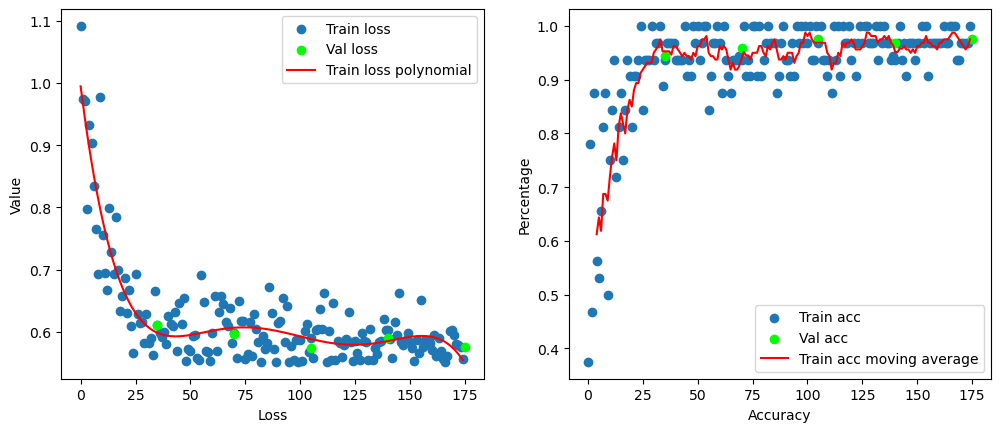

In [14]:
plotting(first_train_losses, first_val_losses, first_train_accs, first_val_accs, 35, 5, 5) 

In [12]:
# YOUR CODE HERE

# Make test data of type DataLoader
test_dataloader = DataLoader(InstrumentsData("test", transform), batch_size = 32, shuffle=True)

accuracy = 0.0
correct_values = 0
y_predictions = []
y_correct = []
# Perform test with no adagrad
with torch.no_grad():
    for batch_x_value, batch_y_value in test_dataloader:
        prediction = network(batch_x_value)
        loss = loss_fn(prediction, batch_y_value)
    
        hard_preds = prediction.argmax(dim=1)
        y_predictions.extend(hard_preds)
        y_correct.extend(batch_y_value)
        
        correct_values += (hard_preds == batch_y_value).sum().item()
        
        accuracy = correct_values/len(InstrumentsData("test", transform))    
    
    print('Test acc: {:.2f} '.format(accuracy))

Test acc: 0.72 


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
confmat = confusion_matrix(y_correct, y_predictions)
names = ['Guitar', 'Piano', 'Drum']
df_cm = pd.DataFrame(confmat / np.sum(confmat, axis=1)[:, None], index = [i for i in names],
                     columns = [i for i in names])

# Plot matrix and add colours
plt.figure(figsize=(5,3))
sn.heatmap(df_cm, annot=True)

ValueError: Shape of passed values is (2, 2), indices imply (3, 3)